## 파라미터 튜닝으로 모델의 성능 개선하기

## 데이터셋 출처
* [Pima Indians Diabetes Database | Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html


### 데이터 구성

* Pregnancies : 임신 횟수
* Glucose : 2시간 동안의 경구 포도당 내성 검사에서 혈장 포도당 농도 
* BloodPressure : 이완기 혈압 (mm Hg)
* SkinThickness : 삼두근 피부 주름 두께 (mm), 체지방을 추정하는데 사용되는 값
* Insulin : 2시간 혈청 인슐린 (mu U / ml)
* BMI : 체질량 지수 (체중kg / 키(m)^2)
* DiabetesPedigreeFunction : 당뇨병 혈통 기능
* Age : 나이
* Outcome : 768개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0입니다.


## 필요한 라이브러리 로드

In [1]:
# 필요한 라이브러리 로드합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 데이터 로드하기

In [2]:
df = pd.read_csv("http://bit.ly/data-diabetes-csv")
df.shape

(768, 9)

In [3]:
# 데이터 프레임에서 가장 앞에 있는 5개의 행(기본값)을 출력합니다.
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 전처리

In [4]:
df["Insulin_nan"] = df["Insulin"].replace(0, np.nan)
in_desc = df.groupby("Outcome")["Insulin_nan"].describe() # 답안으로 통계나고 Insulin_nan 만 봄
in_desc

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,264.0,130.287879,102.482237,15.0,66.0,102.5,161.25,744.0
1,130.0,206.846154,132.699898,14.0,127.5,169.5,239.25,846.0


In [5]:
in_desc.loc[0, "50%"]

102.5

In [6]:
# 인슐린 0 값 중앙값으로 대체

df["Insulin_filled"] = df["Insulin"] 

df.loc[(df["Insulin"] == 0) & (df["Outcome"] == 0), "Insulin_filled"] = in_desc.loc[0, "50%"]
df.loc[(df["Insulin"] == 0) & (df["Outcome"] == 1), "Insulin_filled"] = in_desc.loc[1, "50%"]

In [7]:
df.groupby("Outcome")["Insulin_filled"].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,500.0,117.172000,75.685302,15.0,95.0,102.5,105.0,744.0
1,268.0,187.615672,94.114420,14.0,169.5,169.5,169.5,846.0


## 학습, 예측 데이터셋 나누기

### 정답값이자 예측해야 될 값

In [8]:
# label_name 이라는 변수에 예측할 컬럼 이름을 담습니다.
# label_name
label_name = "Outcome"
label_name

'Outcome'

### 학습, 예측에 사용할 컬럼

In [15]:

# 학습, 예측에 사용할 컬럼에 이름 지정합니다.
feature_names = df.columns.tolist()
feature_names.remove(label_name)
feature_names.remove("Insulin")
feature_names.remove("Insulin_nan")
feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Insulin_filled']

### 문제(feature)와 답안(label)을 나누기

* X, y를 만들어 줍니다.
* X는 feature, 독립변수, 예) 시험의 문제
* y는 label, 종속변수, 예) 시험의 정답

In [16]:
# X, y를 만들어 줍니다.
X = df[feature_names]
y = df[label_name]
X.shape, y.shape

((768, 8), (768,))

### 학습, 예측 데이터셋 만들기
* X_train : 학습 세트 만들기, 행렬, 판다스의 데이터프레임, 2차원 리스트(배열) 구조,  예) 시험의 기출문제
* y_train : 정답 값을 만들기, 벡터, 판다스의 시리즈, 1차원 리스트(배열) 구조, 예) 기출문제의 정답
* X_test : 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제
* y_test : 예측의 정답값 예) 실전 시험 문제의 정답

In [17]:
y.value_counts(normalize=True) * 100

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

In [18]:
# train_test_split 으로 무작위로 데이터셋을 train 과 test 로 나눕니다.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)   # train_size : default = 0.25

In [19]:
# 데이터의 행과 열의 개수를 확인합니다.

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

### stratify 로 클래스 별로 균등하게 잘 나뉘었는지 확인

In [14]:
y_train.value_counts(normalize=True) * 100

0    65.14658
1    34.85342
Name: Outcome, dtype: float64

In [16]:
y_test.value_counts(normalize=True) * 100

0    64.935065
1    35.064935
Name: Outcome, dtype: float64

## 머신러닝 모델

## 하이퍼파라미터 튜닝

* 하이퍼파라미터 (Hyper Parameter)
    * 머신러닝 모델을 생성할 때 사용자가 직접 설정하는 값으로, 이를 어떻게 설정하느냐에 따라 모델의 성능이 달라집니다.
    
* 수동튜닝
    * 만족할만한 하이퍼파라미터들의 조합을 찾을 때까지 수동으로 조정

* GridSearchCV()
    * 시도할 하이퍼파라미터들을 지정하면, 모든 조합에 대해 교차검증 후 가장 좋은 성능을 내는 하이퍼파라미터 조합을 찾음

* RandomizedSearchCV()
    * GridSearch 와 동일한 방식으로 사용하지만 모든 조합을 다 시도하지는 않고, 각 반복마다 임의의 값만 대입해 지정한 횟수만큼 평가

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict

In [18]:
# 트리의 깊이
max_depth_list = [2, 3, 5, 7, 9, 10]
max_depth_list

[2, 3, 5, 7, 9, 10]

In [19]:
np.random.uniform(0.2, 0.6, 10)

array([0.50311218, 0.23648406, 0.32984214, 0.40904564, 0.41747166,
       0.46658473, 0.37279072, 0.49247353, 0.58817069, 0.48607173])

In [20]:
# max_features 비율
max_features_list = [0.4, 0.5, 0.6]
max_features_list

[0.4, 0.5, 0.6]

In [21]:
# accuracy_list = []
# for max_depth in max_depth_list:
#     for max_features in max_features_list:
#         acc_list = []
#         model = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, random_state=42)
#         y_predict = cross_val_predict(model, X_train, y_train, cv=3, n_jobs=-1)
#         acc = (y_train == y_predict).mean()

#         acc_list.append(max_depth)
#         acc_list.append(max_features)
#         acc_list.append(acc)
#         accuracy_list.append(acc_list)

In [22]:
# df_acc = pd.DataFrame(accuracy_list, columns=["max_depth", "max_features", "accuracy"])
# df_acc.nlargest(5, "accuracy")

### GridSearch

In [23]:
model = DecisionTreeClassifier(random_state=42)
model

DecisionTreeClassifier(random_state=42)

In [24]:
max_depth_list = np.random.randint(2, 7, 10)
max_depth_list = np.unique(max_depth_list)
max_depth_list

array([2, 4, 5, 6])

In [25]:
max_features_list = np.random.uniform(0.3, 0.7, 10)
max_features_list

array([0.39700539, 0.62445215, 0.32097601, 0.6683319 , 0.40022096,
       0.64341675, 0.62017772, 0.41473814, 0.59189586, 0.52402812])

In [30]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': max_depth_list, 'max_features': max_features_list}

clf = GridSearchCV(model, param_grid=parameters, scoring="accuracy", n_jobs=-1, cv=5, verbose=2)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([2, 3, 4, 5, 6]),
                         'max_features': array([0.39700539, 0.62445215, 0.32097601, 0.6683319 , 0.40022096,
       0.64341675, 0.62017772, 0.41473814, 0.59189586, 0.52402812])},
             scoring='accuracy', verbose=2)

In [31]:
clf.best_score_

0.858296681327469

In [32]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=6, max_features=0.6683319042134976,
                       random_state=42)

In [33]:
pd.DataFrame(clf.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
45,0.005585,7.985020e-04,0.003790,7.476446e-04,6,0.643417,"{'max_depth': 6, 'max_features': 0.64341675341...",0.813008,0.878049,0.869919,0.878049,0.852459,0.858297,0.024497,1
43,0.006782,1.162549e-03,0.003192,7.461236e-04,6,0.668332,"{'max_depth': 6, 'max_features': 0.66833190421...",0.813008,0.878049,0.869919,0.878049,0.852459,0.858297,0.024497,1
49,0.004700,4.849890e-04,0.002452,4.543116e-04,6,0.524028,"{'max_depth': 6, 'max_features': 0.52402812212...",0.869919,0.878049,0.829268,0.861789,0.844262,0.856657,0.017684,3
46,0.005386,4.882663e-04,0.002793,3.989936e-04,6,0.620178,"{'max_depth': 6, 'max_features': 0.62017771858...",0.869919,0.878049,0.829268,0.861789,0.844262,0.856657,0.017684,3
48,0.004587,4.889284e-04,0.002394,4.898237e-04,6,0.591896,"{'max_depth': 6, 'max_features': 0.59189585664...",0.869919,0.878049,0.829268,0.861789,0.844262,0.856657,0.017684,3
41,0.006383,7.978806e-04,0.003391,7.982974e-04,6,0.624452,"{'max_depth': 6, 'max_features': 0.62445214666...",0.869919,0.878049,0.829268,0.861789,0.844262,0.856657,0.017684,3
39,0.006383,1.017028e-03,0.003591,7.987264e-04,5,0.524028,"{'max_depth': 5, 'max_features': 0.52402812212...",0.861789,0.861789,0.861789,0.845528,0.844262,0.855031,0.008286,7
38,0.006183,1.323463e-03,0.002793,3.984214e-04,5,0.591896,"{'max_depth': 5, 'max_features': 0.59189585664...",0.861789,0.861789,0.861789,0.845528,0.844262,0.855031,0.008286,7
36,0.005385,1.351833e-03,0.002993,6.306019e-04,5,0.620178,"{'max_depth': 5, 'max_features': 0.62017771858...",0.861789,0.861789,0.861789,0.845528,0.844262,0.855031,0.008286,7
31,0.005385,1.018037e-03,0.002593,4.888128e-04,5,0.624452,"{'max_depth': 5, 'max_features': 0.62445214666...",0.861789,0.861789,0.861789,0.845528,0.844262,0.855031,0.008286,7


### RandomSearchCV

In [34]:
max_depth_list = np.random.randint(2, 7, 10)
max_depth_list = np.unique(max_depth_list)
max_depth_list

array([2, 3, 5, 6])

In [35]:
max_features_list = np.random.uniform(0.5, 0.98, 5)
max_features_list

array([0.90931959, 0.86697688, 0.8353597 , 0.91989115, 0.92633106])

In [36]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {"max_depth": np.unique(np.random.randint(2, 7, 10)), 
                       "max_features": np.random.uniform(0.5, 0.98, 5)}
clf = RandomizedSearchCV(model, param_distributions, n_iter=5, cv=6, 
                         n_jobs=-1, verbose=2, random_state=42)
clf.fit(X_train, y_train)

Fitting 6 folds for each of 5 candidates, totalling 30 fits


RandomizedSearchCV(cv=6, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': array([2, 3, 4, 5, 6]),
                                        'max_features': array([0.74809867, 0.51161819, 0.71872377, 0.57863102, 0.77005269])},
                   random_state=42, verbose=2)

In [37]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features=0.5116181886897082,
                       random_state=42)

In [38]:
clf.best_score_

0.8534805507963702

In [39]:
pd.DataFrame(clf.cv_results_).nsmallest(5,"rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
1,0.004652,0.000743,0.002662,0.000747,0.511618,5,"{'max_features': 0.5116181886897082, 'max_dept...",0.854369,0.815534,0.892157,0.872549,0.823529,0.862745,0.853481,0.026718,1
3,0.005486,0.001255,0.002494,0.000762,0.578631,6,"{'max_features': 0.5786310204511778, 'max_dept...",0.834951,0.834951,0.872549,0.882353,0.784314,0.843137,0.842043,0.031596,2
4,0.004325,0.000472,0.001824,0.000686,0.511618,4,"{'max_features': 0.5116181886897082, 'max_dept...",0.883495,0.796117,0.872549,0.833333,0.774510,0.872549,0.838759,0.041353,3
0,0.004654,0.001245,0.002660,0.000470,0.578631,3,"{'max_features': 0.5786310204511778, 'max_dept...",0.844660,0.805825,0.862745,0.833333,0.823529,0.852941,0.837172,0.018895,4
2,0.005320,0.001370,0.003490,0.000954,0.748099,2,"{'max_features': 0.748098674125978, 'max_depth...",0.834951,0.796117,0.852941,0.823529,0.803922,0.833333,0.824132,0.019259,5


## Best Estimator

In [40]:
# 데이터를 머신러닝 모델로 학습(fit)합니다.
best_model = clf.best_estimator_
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_features=0.5116181886897082,
                       random_state=42)

In [41]:
# 데이터를 머신러닝 모델로 예측(predict)합니다.
y_predict = best_model.predict(X_test)
y_predict[:5]

array([0, 0, 0, 1, 0], dtype=int64)

## 모델 평가하기

In [42]:
# feature_importances_ 를 통해 모델의 피처 중요도를 추출합니다.
best_model.feature_importances_

array([0.00835682, 0.13229679, 0.01034036, 0.09540118, 0.01274828,
       0.01878292, 0.06826214, 0.6538115 ])

<AxesSubplot:>

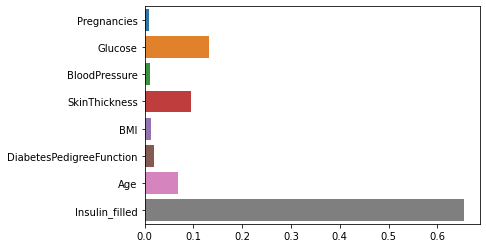

In [43]:
# 피처 중요도를 시각화 합니다.
sns.barplot(x=best_model.feature_importances_, y=feature_names)

### 점수 측정하기
#### Accuracy

In [44]:
(y_test == y_predict).mean()

0.8896103896103896